<a href="https://colab.research.google.com/github/ayulockin/DataAugmentationTF/blob/master/Keras_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setups, Installations and Imports

In [ ]:
!nvidia-smi

Thu Jun 25 15:23:47 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%%capture
!pip install wandb

In [ ]:
SEED = 666

import tensorflow as tf
tf.random.set_seed(SEED)

from tensorflow import keras
from tensorflow.keras.datasets import cifar10

In [ ]:
import os
os.environ["TF_DETERMINISTIC_OPS"] = "1"

import numpy as np
np.random.seed(SEED)

import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import Image

In [ ]:
import wandb
from wandb.keras import WandbCallback

wandb.login()

<IPython.core.display.Javascript object>

wandb: ERROR Not authenticated.  Copy a key from https://app.wandb.ai/authorize


API Key: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Download and Prepare Dataset

#### CIFAR-10

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 7s 0us/step


In [ ]:
CLASS_NAMES = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [ ]:
print('Shape of x_train: ', x_train.shape)
print('Shape of y_train: ', y_train.shape)
print('Shape of x_test: ', x_test.shape)
print('Shape of y_test: ', y_test.shape)

Shape of x_train:  (50000, 32, 32, 3)
Shape of y_train:  (50000, 1)
Shape of x_test:  (10000, 32, 32, 3)
Shape of y_test:  (10000, 1)


# Visualize

In [ ]:
# Ref: https://www.tensorflow.org/tutorials/load_data/images
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[int(label_batch[n])])
      plt.axis('off')

# Dataloader

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
IMG_SHAPE = 32
CHANNELS = 3
NUM_CLASSES = 10

In [ ]:
def preprocess_image(image, label):
  image = image/255
  image = tf.image.convert_image_dtype(image, tf.float32)
  return image, label

In [ ]:
trainloader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
testloader = tf.data.Dataset.from_tensor_slices((x_test, y_test))

trainloader = (
    trainloader
    .shuffle(1024)
    .map(preprocess_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

testloader = (
    testloader
    .map(preprocess_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

(32, 32, 32, 3) (32, 1)


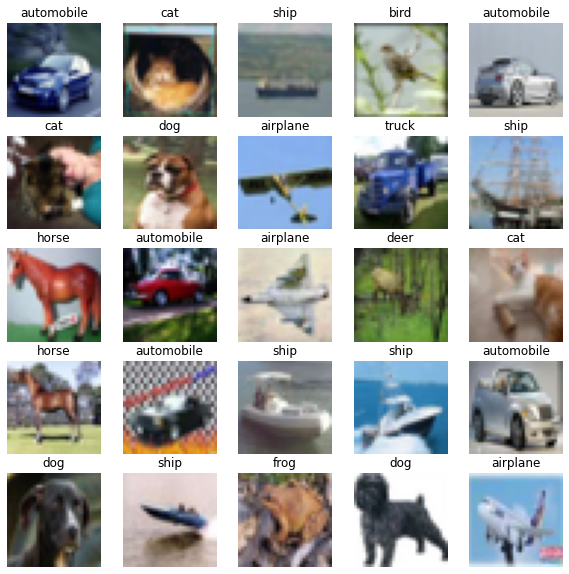

In [ ]:
image_batch, label_batch = next(iter(trainloader))
print(image_batch.shape, label_batch.shape)

show_batch(image_batch, label_batch)

# Model

In [ ]:
def Model():
  inputs = keras.layers.Input(shape=(IMG_SHAPE, IMG_SHAPE, CHANNELS))

  x = keras.layers.Conv2D(filters=32, 
                          kernel_size=(3,3),
                          strides=(1,1),
                          padding='valid',
                          activation='relu')(inputs)

  x = keras.layers.Conv2D(filters=32, 
                          kernel_size=(3,3),
                          strides=(1,1),
                          padding='valid',
                          activation='relu')(x)

  x = keras.layers.MaxPooling2D(pool_size=2)(x)

  x = keras.layers.GlobalAveragePooling2D()(x)

  x = keras.layers.Dense(128, activation='relu')(x)
  x = keras.layers.Dense(32, activation='relu')(x)
  
  outputs = keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

  return keras.models.Model(inputs=inputs, outputs=outputs)

# Callbacks

In [ ]:
earlystoper = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, verbose=0, mode='auto',
    restore_best_weights=True ## This will ensure the best instance of the model over the validation set.
)

# Initialize Model

In [ ]:
keras.backend.clear_session()
model = Model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 128)               4224      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128  

# Compile

In [ ]:
model.compile('adam', 'sparse_categorical_crossentropy', metrics=['acc'])

# Wandb Init

In [ ]:
wandb.init(entity='authors', project='seo')

W&B Run: https://app.wandb.ai/authors/seo/runs/2e8mz05f

# Train

In [ ]:
val_images, val_labels = next(iter(testloader))

In [ ]:
EPOCHS = 100

_ = model.fit(trainloader,
          epochs=EPOCHS,
          validation_data=testloader,
          callbacks=[WandbCallback(data_type='image', 
                                   training_data=(val_images, val_labels), 
                                   labels=CLASS_NAMES),
                     earlystoper])

Epoch 1/100
1563/1563 [==============================] - 8s 5ms/step - loss: 1.8840 - acc: 0.2747 - val_loss: 1.6998 - val_acc: 0.3532
Epoch 2/100
1563/1563 [==============================] - 8s 5ms/step - loss: 1.6723 - acc: 0.3582 - val_loss: 1.5938 - val_acc: 0.4019
Epoch 3/100
1563/1563 [==============================] - 8s 5ms/step - loss: 1.5799 - acc: 0.4047 - val_loss: 1.5524 - val_acc: 0.4280
Epoch 4/100
1563/1563 [==============================] - 8s 5ms/step - loss: 1.4870 - acc: 0.4514 - val_loss: 1.5096 - val_acc: 0.4486
Epoch 5/100
1563/1563 [==============================] - 8s 5ms/step - loss: 1.4181 - acc: 0.4794 - val_loss: 1.4337 - val_acc: 0.4696
Epoch 6/100
1563/1563 [==============================] - 8s 5ms/step - loss: 1.3725 - acc: 0.4973 - val_loss: 1.3853 - val_acc: 0.4895
Epoch 7/100
1563/1563 [==============================] - 8s 5ms/step - loss: 1.3380 - acc: 0.5119 - val_loss: 1.3193 - val_acc: 0.5236
Epoch 8/100
1563/1563 [==============================] 

# Evaluate

In [ ]:
loss, accuracy = model.evaluate(testloader, callbacks=[WandbCallback()])
print('Test Error Rate: ', round((1-accuracy)*100, 2))
wandb.log({'Test Error Rate': round((1-accuracy)*100, 2)})

313/313 [==============================] - 1s 3ms/step - loss: 0.9600 - acc: 0.6634
Test Error Rate:  33.66


# Let's Increase Model Capacity

#### New Model

In [ ]:
def ModelIncCapacity():
  inputs = keras.layers.Input(shape=(IMG_SHAPE, IMG_SHAPE, CHANNELS))

  x = keras.layers.Conv2D(filters=32, 
                          kernel_size=(3,3),
                          strides=(1,1),
                          padding='valid',
                          activation='relu')(inputs)

  x = keras.layers.Conv2D(filters=32, 
                          kernel_size=(3,3),
                          strides=(1,1),
                          padding='valid',
                          activation='relu')(x)

  x = keras.layers.MaxPooling2D(pool_size=2)(x)

  x = keras.layers.Conv2D(filters=32, 
                          kernel_size=(3,3),
                          strides=(1,1),
                          padding='valid',
                          activation='relu')(x)

  x = keras.layers.Conv2D(filters=32, 
                          kernel_size=(3,3),
                          strides=(1,1),
                          padding='valid',
                          activation='relu')(x)

  x = keras.layers.GlobalAveragePooling2D()(x)

  x = keras.layers.Dense(128, activation='relu')(x)
  x = keras.layers.Dense(32, activation='relu')(x)
  
  outputs = keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

  return keras.models.Model(inputs=inputs, outputs=outputs)

#### Initialize Model

In [ ]:
keras.backend.clear_session()
model = ModelIncCapacity()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 32)        9248      
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0     

#### Compile

In [ ]:
model.compile('adam', 'sparse_categorical_crossentropy', metrics=['acc'])

#### Wandb Init

In [ ]:
wandb.init(entity='authors', project='seo')

W&B Run: https://app.wandb.ai/authors/seo/runs/2p3h30jq

#### Train

In [ ]:
EPOCHS = 100

_ = model.fit(trainloader,
          epochs=EPOCHS,
          validation_data=testloader,
          callbacks=[WandbCallback(data_type='image', 
                                   training_data=(val_images, val_labels), 
                                   labels=CLASS_NAMES),
                     earlystoper])

Epoch 1/100
1563/1563 [==============================] - 10s 6ms/step - loss: 1.7897 - acc: 0.3103 - val_loss: 1.6118 - val_acc: 0.3787
Epoch 2/100
1563/1563 [==============================] - 9s 6ms/step - loss: 1.4931 - acc: 0.4423 - val_loss: 1.3941 - val_acc: 0.4856
Epoch 3/100
1563/1563 [==============================] - 9s 6ms/step - loss: 1.3001 - acc: 0.5265 - val_loss: 1.1926 - val_acc: 0.5609
Epoch 4/100
1563/1563 [==============================] - 9s 5ms/step - loss: 1.1785 - acc: 0.5730 - val_loss: 1.2196 - val_acc: 0.5659
Epoch 5/100
1563/1563 [==============================] - 9s 6ms/step - loss: 1.0917 - acc: 0.6058 - val_loss: 1.0552 - val_acc: 0.6157
Epoch 6/100
1563/1563 [==============================] - 9s 6ms/step - loss: 1.0289 - acc: 0.6292 - val_loss: 1.0217 - val_acc: 0.6262
Epoch 7/100
1563/1563 [==============================] - 9s 6ms/step - loss: 0.9833 - acc: 0.6469 - val_loss: 1.0305 - val_acc: 0.6295
Epoch 8/100
1563/1563 [==============================]

#### Evaluate

In [ ]:
loss, accuracy = model.evaluate(testloader, callbacks=[WandbCallback()])
print('Test Error Rate: ', round((1-accuracy)*100, 2))
wandb.log({'Test Error Rate': round((1-accuracy)*100, 2)})

313/313 [==============================] - 1s 3ms/step - loss: 0.7761 - acc: 0.7318
Test Error Rate:  26.82
